# Predict PDF parameters from offshore data

In [4]:
# ------------------------------------------------------------------------
# ------------------------------------------------------------------------
#
# SCRIPT   : predict.py
# POURPOSE : predict swash PDF using kown variables Hm0 and Tm01
#
# AUTHOR   : Caio Eadi Stringari
# EMAIL    : Caio.EadiStringari@uon.edu.au
#
# v1.0     : 06/09/2018 [Caio Stringari]
#
# ------------------------------------------------------------------------
# ------------------------------------------------------------------------


In [5]:
import sys
import warnings

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, RobustScaler

import xgboost

from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

# plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from string import ascii_lowercase
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})
sns.set_style("ticks", {'axes.linewidth': 2,
                        'legend.frameon': True,
                        'axes.facecolor': "#E9E9F1",
                        'grid.color': "w"})
mpl.rcParams['axes.linewidth'] = 2

# quite scipy warningss
warnings.filterwarnings("ignore")

In [6]:
def main():
    """Run the XGB predictor."""
    
    # load Y matix (target mu, sigma and alpha)
    Y = np.load("y.npy", allow_pickle=True)
    
    # load offshore data (input Hm0 at Tm01 )
    df = pd.read_csv("X.csv")
    X = df[["Hm0", "Tm01"]].values

    # split into train/test
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, shuffle=True,
                                                    test_size=0.3,
                                                    train_size=0.7,
                                                    random_state=42)

    # ---- fit and predict ---- #

    # Hyper parameters - DO NOT CHANGE !
    N = 64
    MAX_DEPTH = 8
    
    # fit
    Ypred = []
    for i in range(Ytrain.shape[1]):
        eval_set = [(Xtest, Ytest[:, i])]
        M = xgboost.XGBRegressor(max_depth=MAX_DEPTH, n_estimators=N,
                                 eval_set=eval_set, eval_metric="rmse",
                                 early_stopping_rounds=50)
        M.fit(Xtrain, Ytrain[:, i])
        pred = M.predict(Xtest)
        Ypred.append(pred)
        
    # predict
    Ypred = np.array(Ypred).T

    # ---- plot ---- #

    bbox = dict(boxstyle="square", ec="none", fc="1", lw=1, alpha=0.7)
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    axs = axs.flatten()

    # plot learnt representations
    skw = {"color": "k", "alpha": 0.5, "s": 60, "edgecolor": "w"}
    for i in range(Ytest.shape[1]):
        sns.regplot(Ytest[:, i], Ypred[:, i], ax=axs[i], color="r",
                    scatter_kws=skw)
        axs[i].plot((-10, 10), (-10, 10), color="k", lw=1, ls="--")

    # add stats
    for i in range(Ytest.shape[1]):
        # r_xy
        r, p = pearsonr(Ytest[:, i], Ypred[:, i])
        t = r"$r_{xy}$" + "={0:.2f}, $p \ll 0$".format(r)
        axs[i].text(0.95, 0.1, t,
                    transform=axs[i].transAxes, ha="right",
                    va="center", bbox=bbox, zorder=100)

    # set limits
    for i in range(Ytest.shape[1]):
        axs[i].set_xlim(Ytest[:, i].min(), Ytest[:, i].max())
        axs[i].set_ylim(Ytest[:, i].min(), Ytest[:, i].max())

    for ax in axs:
        ax.grid(color="w", ls="-", lw=2)
        sns.despine(ax=ax)

    k = 0
    for i in [0, 1, 2]:
        axs[i].set_xlabel(r"$\mu$ $[-]$")
        if k == 0:
            axs[i].set_ylabel(r"Predicted $\mu$ $[-]$")
            k = 1
        axs[i].set_title("Mixture {}".format(i+1), fontsize=14)

    k = 0
    for i in [3, 4, 5]:
        axs[i].set_xlabel(r"$\sigma$ $[-]$")
        if k == 0:
            axs[i].set_ylabel(r"Predicted $\sigma$ $[-]$")
            k = 1

    k = 0
    for i in [6, 7, 8]:
        axs[i].set_xlabel(r"$\alpha$ $[-]$")
        if k == 0:
            axs[i].set_ylabel(r"Predicted $\alpha$ $[-]$")
            k = 1
        # axs[i].set_title("Mixture {}".format(i-5), fontsize=14)

    # add letters
    for i in range(Ytest.shape[1]):
        axs[i].text(0.05, 0.925, ascii_lowercase[i]+")",
                    transform=axs[i].transAxes, ha="left",
                    va="center", bbox=bbox, zorder=100)

    # finalise
    fig.tight_layout()
    plt.savefig("xgb_prediction.png", dpi=300, bbox_inches='tight',
                pad_inches=0.2)
    plt.show()
    plt.close()
    

Analysing data, please wait...



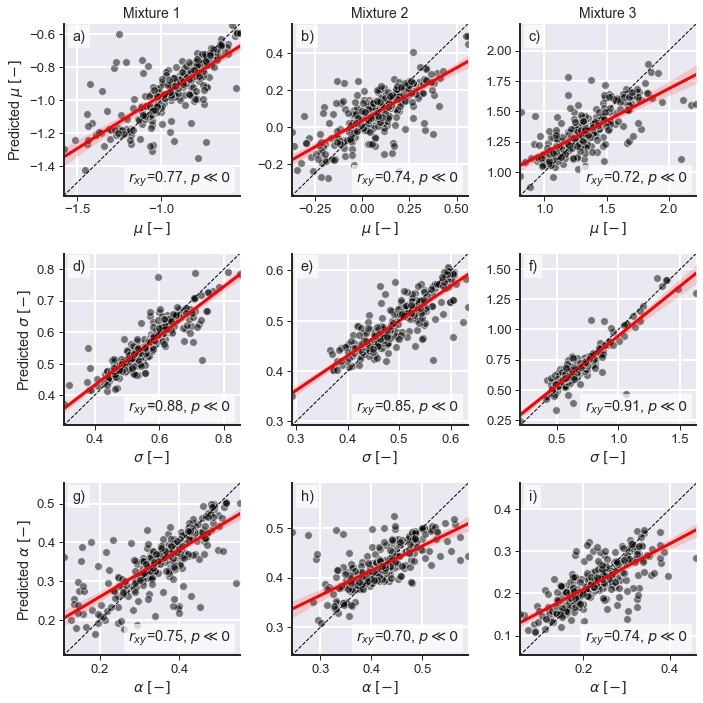


My work is done!



In [7]:
if __name__ == '__main__':
    print("Analysing data, please wait...\n")
    main()
    print("\nMy work is done!\n")
    